# This is the minimum Working Example to compute a multiple scattering experiment in the Q-Phase 

In [1]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Sat Jun 10 19:53:32 2017

@author: Bene

This file creates a fwd-model for the TESCAN Q-PHASE under 
multiple-scattering. It is majorly derived from  "LEarning approach for optical tomography"
U. S. Kamilov, BIG, EPFL, 2014.
"""
%load_ext autoreload
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import h5py 
import scipy.io
import scipy as scipy
import scipy.misc

# load own functions
from src import tf_helper as helper
from src import muscat as mus
from src import tf_generate_object as tf_go
from src import data as data

# Define some optimization parameters 

In [2]:

optimize = 0#0# want to optimize for the refractive index?

my_learningrate = 1e-3# learning rate
my_keep_prob = 1
tv_lambda = 1e-2
gr_lambda = 1e-2
obj_reg_lambda = 1e9

load_data = 0 # want to load previously stored data from disk (numpy) otherwise MATLAB experiment will be loaded    


# Define the location for the files; it is expected to be in the MATLAB -v7.3 format
# The parameter file has a struct-object called myParameter with all necessary variables
# The dataset file holds a complex matrix with Nx * Ny * Nz voxels called allAmpSimu
matlab_par_file = './Data/BEADS/Beads_40x_100a_myParameter.mat'   # File with the experimental Parameters
matlab_val_file = './Data/BEADS/Beads_40x_100a_allAmp.mat'   # File that stores the 3D (complex) Amplitude

In [3]:
# This is the place to load data
''' File which stores the experimental parameters from the Q-PHASE setup 
    1.) Read in the parameters of the dataset ''' 
matlab_pars = data.import_parameters_mat(filename = matlab_par_file)

''' 2.) Read in the parameters of the dataset ''' 
matlab_val = data.import_realdata_h5(filename = matlab_val_file, matname='allAmpSimu', is_complex=True)

# Initiate the MuScat (Multiple Scattering) Object

In [4]:
''' Create the Model'''
mm = mus.MuScatModel(matlab_pars, optimize, my_learningrate, my_keep_prob, tv_lambda, obj_reg_lambda, gr_lambda) # First initiliaze it

''' Adjust some parameters to fit it in the memory '''
#mm.Nz, mm.Nx, mm.Ny = np.shape(np_allAmpSimu)
mm.Nz=100#int( np.double(np.array(self.myParamter.get('Nz'))))
mm.Nx=100#np.int(np.floor((2*self.Rsim)/self.dx)+1);
mm.Ny=100#np.int(np.floor((2*self.Rsim)/self.dy)+1)
mm.NAc = 0.1 

## Compute the System's properties (e.g. Pupil function/Illumination Source, K-vectors, etc.)

In [5]:
''' Compute the systems model'''
mm.computeSys()

Number of Illumination Angles / Plane waves: 13


Now load data which has been saved previously (Optional!)

In [6]:
# Load Copute the systems model
if(load_data):
    mm.loadData()
else:
    mm.allSumAmp_mes = matlab_val

## Generate a phantom object in 3D 

In [7]:
''' Create a 3D Refractive Index Distributaton as a artificial sample'''
obj = tf_go.generateObject(obj_shape=mm.mysize, obj_dim=mm.dx, obj_type = 4, diameter = 1, dn = mm.dn)

## Create computational graph

In [8]:
''' Assign Object (3D sample) to Class'''
mm.obj_init = tf_go.generateInitObject(obj)

''' Create computational graph'''
mm.create_graph(obj, if_xla=0)


Start interactive Session
no XLA activvated
Generate Object
Buildup Q-PHASE Model 
Current Z-Slice # is: 0
Current Z-Slice # is: 1
Current Z-Slice # is: 2
Current Z-Slice # is: 3
Current Z-Slice # is: 4
Current Z-Slice # is: 5
Current Z-Slice # is: 6
Current Z-Slice # is: 7
Current Z-Slice # is: 8
Current Z-Slice # is: 9
Current Z-Slice # is: 10
Current Z-Slice # is: 11
Current Z-Slice # is: 12
Current Z-Slice # is: 13
Current Z-Slice # is: 14
Current Z-Slice # is: 15
Current Z-Slice # is: 16
Current Z-Slice # is: 17
Current Z-Slice # is: 18
Current Z-Slice # is: 19
Current Z-Slice # is: 20
Current Z-Slice # is: 21
Current Z-Slice # is: 22
Current Z-Slice # is: 23
Current Z-Slice # is: 24
Current Z-Slice # is: 25
Current Z-Slice # is: 26
Current Z-Slice # is: 27
Current Z-Slice # is: 28
Current Z-Slice # is: 29
Current Z-Slice # is: 30
Current Z-Slice # is: 31
Current Z-Slice # is: 32
Current Z-Slice # is: 33
Current Z-Slice # is: 34
Current Z-Slice # is: 35
Current Z-Slice # is: 36
Cu

## Now evaluate the result - start inference

In [9]:
'''Compute result'''    
mm.eval_graph() # result will be stored in mm.allSumAmp

# mm.inference(obj, if_xla=0)

Object will be taken from Class
start evaluating your computational graph



## Visualize Results


(100, 100, 100)


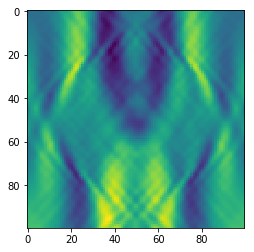

In [16]:
print(mm.allSumAmp.shape)
plt.imshow(np.abs(mm.allSumAmp[:,:,int(mm.Nx/2)]))
# mm.visualize_results()

# Add some Regularizers

In [ ]:
mm.regularizer(if_tvreg=True, if_posreg=True)